In [1]:
from pprint import pprint
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import tensorflow as tf
import edward as ed
from edward.models import Bernoulli, Categorical, Normal, Empirical, Multinomial, Dirichlet, Mixture

from utils.utils import load_dataframe, preprocess, transition_matrix

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -1)
sns.set_style('whitegrid')

## Data

In [3]:
df = load_dataframe()

Loading raw data from hdf5 cache...
Fetching raw data took 6.39 seconds
id             int64   
loan_status    category
age_of_loan    int64   
term           category
dtype: object
Retrieved 40,263,987 rows, 4 columns


In [4]:
# note I made this filter on term == 36 and age_of_loan <= 36 
df = preprocess(df)

Mapping transformations...
Loading preprocessed data from hdf5 cache...
Fetching preprocessed data took 4.69 seconds
id             int64
loan_status    int64
age_of_loan    int64
term           int64
dtype: object
Preprocessed 27,636,875 rows, 4 columns


In [5]:
realized_transitions = transition_matrix(df)

Loading transition matrix from hdf5 cache...
Fetching transition matrix took 0.09 seconds


In [6]:
realized_transitions

loan_status_y,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
loan_status_x,,,,,,,,
Charged Off,0,0,0,0,0,0,0,0
Current,774,24450170,3,707161,5831,0,160357,62006
Default,28843,147,2206,71,0,0,4,506
Fully Paid,0,0,0,8063,12,0,101,72
In Grace Period,0,276,0,11,22,0,59,41
Issued,0,17206,0,670,1,0,38,1
Late (16-30 days),4548,32374,0,2066,257,0,13413,119613
Late (31-120 days),105932,25398,29748,2138,56,0,3292,332463


## Sampling and visualizing some trajectories:

In [7]:
unique_id = df.id.unique()

In [8]:
unique_id.shape

(1520925,)

In [7]:
statuses = list(realized_transitions.index)

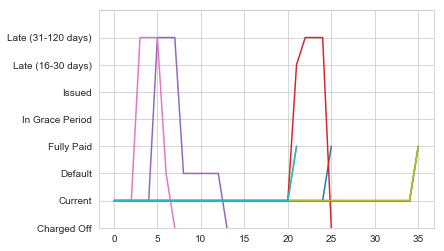

In [27]:
fig, ax = plt.subplots()

ax.set_ylim(0, len(statuses))
ax.set_yticklabels(statuses)

for loan_id in unique_id[:10]:
    ax.plot(df[df.id == loan_id].loan_status.values)

plt.show()

We need to make sure that all trajectories are exactly of length 36, so when they terminate early we should carry on their state until the end (there might be another strategy for that):

First, pivot, to have all trajectories in a matrix:

In [8]:
pivoted = df.pivot(index='id', columns='age_of_loan', values='loan_status')

In [9]:
pivoted.head()

age_of_loan,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54734,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55716,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55742,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0
56121,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,7.0,7.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56413,NaN,1.0,1.0,1.0,1.0,1.0,7.0,7.0,7.0,2.0,2.0,2.0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
pivoted[0].isnull().mean()

0.9771172148528033

Some loans have a value for month 0?

In [11]:
pivoted[~pivoted[0].isnull()].head()

age_of_loan,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
377140,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,NaN,NaN
384586,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582543,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
699575,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
767952,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For now let's just drop them:

In [12]:
pivoted = pivoted[pivoted[0].isnull()]

In [13]:
pivoted.shape

(1486122, 37)

In [14]:
pivoted.drop(0, axis=1, inplace=True)

**TODO** count value per column

We can fill the NaNs with an unused category for a state "done":

In [99]:
df.loan_status.unique()

array([1, 3, 6, 7, 0, 2, 4, 5])

In [15]:
new_status = 8

In [31]:
statuses.append(new_status)

In [16]:
pivoted.fillna(new_status, inplace=True)

In [17]:
pivoted.head()

age_of_loan,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54734,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
55716,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
55742,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0
56121,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,7.0,7.0,7.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
56413,1.0,1.0,1.0,1.0,1.0,7.0,7.0,7.0,2.0,2.0,2.0,2.0,2.0,0.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0


## Modeling without priors, as a HMM (original github issue model):

**MODEL**

In [110]:
N = pivoted.shape[0]

**TODO figure out how to make sample shape work in this case...**

In [ ]:
# from issue 
chain_len = 36
n_hidden = 10 # set this arbitrarily
n_obs = len(statuses)

x_0 = Categorical(probs=tf.fill([n_hidden], 1.0 / n_hidden), sample_shape=N)

# transition matrix
T = tf.nn.softmax(tf.Variable(tf.random_uniform([n_hidden, n_hidden])), dim=0)

# emission matrix
E = tf.nn.softmax(tf.Variable(tf.random_uniform([n_hidden, n_obs])), dim=0)

# MODEL
x = []
y = []
for _ in range(chain_len):
    x_tm1 = x[-1] if x else x_0
    x_t = Categorical(probs=T[x_tm1, :], sample_shape=N)
    y_t = Categorical(probs=E[x_t, :], sample_shape=N)
    x.append(x_t)
    y.append(y_t)

**INFERENCE**

In [ ]:
# INFERENCE
qx = [Categorical(probs=tf.nn.softmax(tf.Variable(tf.ones(n_hidden))))
      for _ in range(chain_len)]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(T))

    inference = ed.KLqp(dict(zip(x, qx)), {y[i]: pivoted[i+1].values for i in range(36)})
    inference.run(n_iter=5000)

    inferred_T, inferred_E = sess.run([T, E])
    inferred_qx = sess.run([foo.probs for foo in qx])
    inferred_y_probs = sess.run([foo.probs for foo in y])
    print(inferred_T)
    print(inferred_E)

## Modeling with priors:

**DATA**

Debug: train on subset of data

In [161]:
N = 1000

In [162]:
subset_pivoted = pivoted.sample(N)

**MODEL**

In [177]:
tf.reset_default_graph()
chain_len = 36
n_states = len(statuses)

# create default starting state probability vector
pi_0 = Dirichlet(tf.ones(n_states))
x_0 = Categorical(pi_0, sample_shape=N)

# transition matrix
pi_T = Dirichlet(tf.ones([n_states, n_states]))

x = []
for _ in range(chain_len):
    x_tm1 = x[-1] if x else x_0
    x_t = Categorical(probs=tf.gather(pi_T, x_tm1))
    x.append(x_t)

**INFERENCE (VI)**

This works, but it's very unstable (sometimes it goes to NaN right before the end). Note that it's important to create the optimizer ourselves to set the learning rate to a lower value than 0.1 (default used by KLqp). But because of that, we can't use the exponential decay of the learning rate, we'd need to re-implement it ourselves (see variational_inference.py in Edward's source code).

**TODO** train by batch

In [202]:
# INFERENCE
qpi_0 = Dirichlet(tf.nn.softplus(tf.Variable(tf.ones(n_states))))
qpi_T = Dirichlet(tf.nn.softplus(tf.Variable(tf.ones([n_states, n_states]))))

# sess = ed.get_session()
# sess.run(tf.global_variables_initializer())

inference = ed.KLqp({pi_0: qpi_0, pi_T: qpi_T},
                        {x[i]: subset_pivoted[i+1].values for i in range(chain_len)})
inference.run(n_iter=20000, optimizer=tf.train.AdamOptimizer(0.005)) # 20K is good for n_iter

20000/20000 [100%] ██████████████████████████████ Elapsed: 126s | Loss: 21253.334


In [203]:
sess = ed.get_session()

In [205]:
inferred_qpi_T_means = sess.run(qpi_T.mean())
inferred_qpi_T_variances = sess.run(qpi_T.variance())

In [206]:
inferred_qpi_T_means

array([[0.12507866, 0.1521298 , 0.11655644, 0.09063223, 0.07130251,
        0.11869185, 0.09772199, 0.08578926, 0.14209728],
       [0.01836592, 0.7634387 , 0.02182396, 0.03624058, 0.02945363,
        0.02198017, 0.03385498, 0.01878545, 0.05605654],
       [0.13416964, 0.0621291 , 0.17049262, 0.09240437, 0.11532754,
        0.11562645, 0.11435907, 0.09916215, 0.09632908],
       [0.1247556 , 0.10845608, 0.10488065, 0.1069215 , 0.13607791,
        0.08673268, 0.08395358, 0.0691779 , 0.17904411],
       [0.04480116, 0.11298703, 0.15584248, 0.13698436, 0.08180825,
        0.11915029, 0.06876207, 0.14109752, 0.13856684],
       [0.13984273, 0.07369735, 0.10660773, 0.1143363 , 0.13324863,
        0.09623411, 0.05735279, 0.12348081, 0.15519951],
       [0.15419373, 0.15321258, 0.04471993, 0.08862256, 0.08727547,
        0.1017881 , 0.12156834, 0.06687341, 0.18174596],
       [0.12674628, 0.1603252 , 0.0780381 , 0.05789593, 0.15856706,
        0.1340742 , 0.05436752, 0.12143074, 0.10855491],


**CRITICISM**

**1) Sampling from the posteriors:**

It's hard to visualize a dirichlet with 9 dim..., maybe we can sample from the dirichlet and then plot a histogram:

Distribution of initial probs:

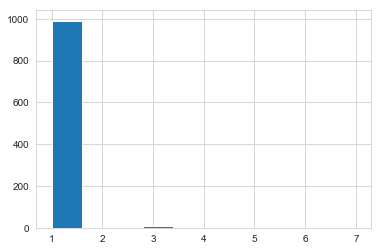

In [208]:
subset_pivoted[1].hist()

In [209]:
sess.run(qpi_0.mean())

array([0.12671629, 0.15557946, 0.1020001 , 0.17225115, 0.02248389,
       0.10509174, 0.12442159, 0.10844812, 0.08300764], dtype=float32)

In [215]:
sess.run(qpi_T.sample()[0])

array([0.28691313, 0.10861389, 0.05722402, 0.148052  , 0.05395943,
       0.18569236, 0.04929283, 0.00302821, 0.10722412], dtype=float32)

So these results are not good, at least 1 and 3 are higher but that's pretty much it...

Somes probability vectors for the first row of the transition matrix:

In [226]:
sess.run(qpi_T.sample(3)).shape

(3, 9, 9)

In [227]:
sess.run(qpi_T.sample(3))[:,0,:] # this is the first row of the matrix for all (3) samples

array([[0.04287062, 0.17406757, 0.18197256, 0.04344246, 0.2797352 ,
        0.00442416, 0.02656656, 0.06735773, 0.17956312],
       [0.06260953, 0.04163804, 0.24805999, 0.2112006 , 0.07530368,
        0.11786164, 0.13934284, 0.02314681, 0.08083687],
       [0.08906402, 0.3897574 , 0.03019128, 0.11365485, 0.13012093,
        0.05224984, 0.03278897, 0.03215479, 0.13001797]], dtype=float32)

Sample 10 probability vectors for second row of transitions (transitions Current -> smth), and plot:

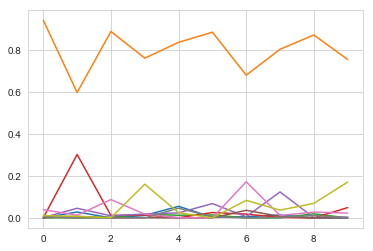

In [228]:
plt.plot(sess.run(qpi_T.sample(10))[:,1,:]);

Same for second row:

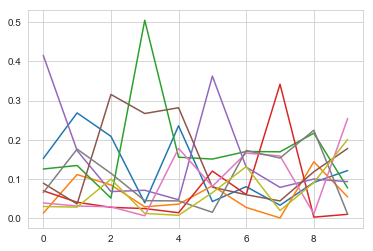

In [229]:
plt.plot(sess.run(qpi_T.sample(10))[:,2,:]);

**2) Generating some trajectories:**

In [230]:
# build model from inferred priors
qx_0 = Categorical(qpi_0, sample_shape=1)
qx = []
for _ in range(chain_len):
    qx_tm1 = qx[-1] if qx else qx_0
    qx_t = Categorical(probs=tf.gather(qpi_T, qx_tm1))
    qx.append(qx_t)

I'm not sure if this is sampling from the qx one by one to build a sequence or just sampling independtly... But the results are weird

In [231]:
sess.run(qx)

[array([1], dtype=int32),
 array([3], dtype=int32),
 array([4], dtype=int32),
 array([1], dtype=int32),
 array([7], dtype=int32),
 array([5], dtype=int32),
 array([3], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([7], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([7], dtype=int32),
 array([0], dtype=int32),
 array([5], dtype=int32),
 array([5], dtype=int32),
 array([3], dtype=int32),
 array([2], dtype=int32),
 array([0], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([8], dtype=int32),
 array([8], dtype=int32),
 array([8], dtype=int32),
 array([8], dtype=int32),
 array([8], dtype=int32),
 array([2], dtype=int32),
 array([7], dtype=int32),
 array([1], dtype=int32),
 array([5], dtype=int32),
 array([1], dtype=int32),
 array([1], dtype=int32),
 array([8], dtype=int32),
 array([8], dtype=int32),
 array([0], dtype=int32)]